In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
num_simulacoes = 700
regrets_all = []

# Ler a coluna de regrets de cada simulação
for i in range(num_simulacoes):
    try:
        sim_path = f"../data/simulations/{i}/sim_results_drift_recor.csv"
        df = pd.read_csv(sim_path, usecols=['regrets'])
        regrets_all.append(df['regrets'].tolist())
    except Exception as e:  # Captura qualquer exceção
        continue

# Convertendo para DataFrame para facilitar os cálculos
regrets_df = pd.DataFrame(regrets_all).T

# Verificando se o regret ultrapassa y=x em cada ponto
exceeds_y_equals_x = regrets_df.apply(lambda x: x > np.arange(len(x)), axis=0)

# Calculando a porcentagem de vezes que o regret ultrapassa y=x
percentage_exceeds = (exceeds_y_equals_x.sum(axis=1) / num_simulacoes) * 100

# Média da porcentagem para todos os pontos (ou um ponto específico se necessário)
average_percentage_exceeds = percentage_exceeds.mean()
# Calculando os quantis
lower_bound = regrets_df.quantile(0.025, axis=1)
upper_bound = regrets_df.quantile(0.975, axis=1)
median_regrets = regrets_df.median(axis=1)
mean_regrets = regrets_df.mean(axis=1)

x_plot = range(len(lower_bound))

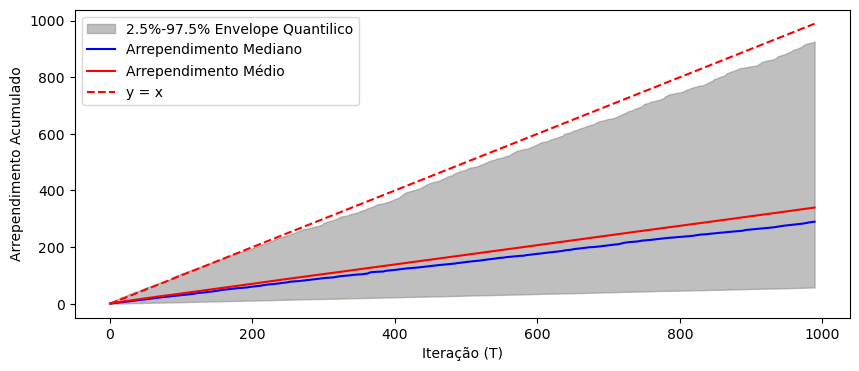

In [3]:
plt.figure(figsize=(10, 4))

plt.fill_between(x_plot, lower_bound, upper_bound, color='gray', alpha=0.5, label='2.5%-97.5% Envelope Quantilico')
plt.plot(x_plot, median_regrets, label='Arrependimento Mediano', color='blue')
plt.plot(x_plot, mean_regrets, label='Arrependimento Médio', color='red')
plt.plot(x_plot, x_plot, label='y = x', color='red', linestyle='--')
plt.xlabel('Iteração (T)')
plt.ylabel('Arrependimento Acumulado')
plt.legend()

plt.savefig('../imagens/regret_drift_recor.png')

plt.show()

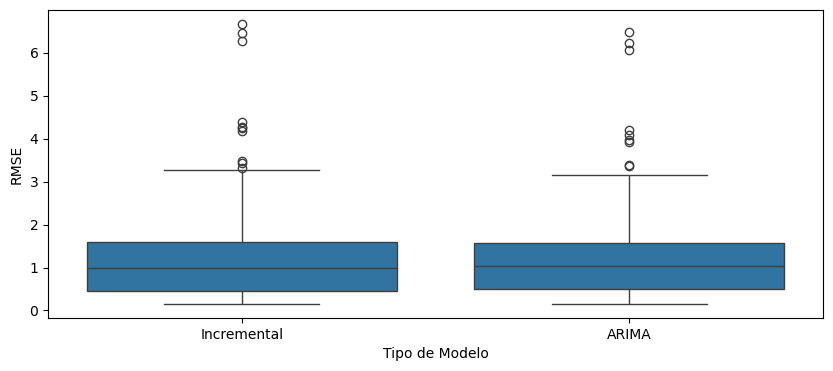

In [5]:
rmse_incremental_list = []
rmse_arima_list = []

for i in range(num_simulacoes):
    try:
        # Caminho para o arquivo CSV da simulação
        sim_path = f"../data/simulations/{i}/sim_results_drift_recor.csv"
        # Carrega o dataframe da simulação
        df = pd.read_csv(sim_path)

        # Assegura que as colunas necessárias estão presentes
        if {'y_real_nowcast', 'y_pred_incremental_nowcast', 'y_pred_arima_nowcast'}.issubset(df.columns):
            # Calcula RMSE para o modelo incremental
            rmse_incremental = sqrt(mean_squared_error(df['y_real_nowcast'], df['y_pred_incremental_nowcast']))
            # Calcula RMSE para o modelo ARIMA
            rmse_arima = sqrt(mean_squared_error(df['y_real_nowcast'], df['y_pred_arima_nowcast']))

            # Adiciona os resultados às listas correspondentes
            rmse_incremental_list.append(rmse_incremental)
            rmse_arima_list.append(rmse_arima)
        else:
            print(f"Simulação {i} não contém todas as colunas necessárias.")

    except Exception as e:  # Captura qualquer exceção e imprime o erro
        print(f"Erro ao processar a simulação {i}: {e}")

rmse_data = pd.DataFrame({
    'Modelo': ['Incremental'] * len(rmse_incremental_list) + ['ARIMA'] * len(rmse_arima_list),
    'RMSE': rmse_incremental_list + rmse_arima_list
})

plt.figure(figsize=(10, 4))
sns.boxplot(x='Modelo', y='RMSE', data=rmse_data)
plt.ylabel('RMSE')
plt.xlabel('Tipo de Modelo')
plt.savefig('../imagens/rmse_drift_incremental.png')
plt.show()